Before starting make sure to attach a kernal with numpy and matplotlib installed.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import random

# Introduction
For our esitmation of pi, we are using the Monte Carlo method. [Wikipedia](https://en.wikipedia.org/wiki/Monte_Carlo_method#:~:text=Monte%20Carlo%20methods%2C%20or%20Monte,might%20be%20deterministic%20in%20principle.) has a verbose article and was the main source I used in the creation of my algoithm. Monte Carlo methods tend to follow a pattern of first defining a domain of possible inputs, generating inputs from some proability distribution over the domain, performing some deterministic computation of the outputs and finally aggregating the results. 

# Approximating $\pi$

Define domain $D = \{(x,y) \in \mathbb{R}^2 | -1 \le x \le 1 \text{ and } -1 \le y \le 1 \} $. 

Define n to be the amount of points containted in D and r to be the amount of points within an inscribed unit circle. 

Then the ratio's of surface area should relate to the ratio of points r and n we have the approximation. 

$\frac{\pi}{4}\approx \frac{r}{n}$

$\pi \approx \frac{4 * r}{n}$

In [78]:
#Monte Carlo pi estimator
def estimate_pi(n):
    #Create random points within unit square
    x = np.random.uniform(0,1,n)
    y = np.random.uniform(0,1,n)

    #Get sum of all points where the distance from center 
    # is less than 1 (inside unit circle)
    r = np.sum(np.sqrt((x)**2+(y)**2)<1)


    return 4 * r / n

One issue that I've seen some peers run into with this project was the efficency of the estimator, while my code could be improved, I found a decent performace uplift with calculating r. First note that I am creating a boolean mask. Then using numpys aggregate function sum can quicly take the amount of true values as 1 and return the sum. Note that count_nonzero also has the same effect.

In [79]:
x = np.random.uniform(0,1,20)
y = np.random.uniform(0,1,20)
mask = np.sqrt((x)**2+(y)**2)<1
sum = np.sum(mask)
sum_alternate = np.count_nonzero(mask)
display(mask,sum,sum_alternate)

array([False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True])

np.int64(17)

np.int64(17)

To show this efficency I asked Gemini to create an estimator and it gave this (I removed the comments it made for sizing, and also made fixed code to specify the np random library method).

In [80]:
def estimate_pi_gemini(num_points):
    points_in_circle = 0
    total_points = num_points

    for _ in range(total_points):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)

        distance_squared = x**2 + y**2

        if distance_squared <= 1:
            points_in_circle += 1

    pi_estimate = 4 * points_in_circle / total_points
    return pi_estimate


Using the [IPython timeit magic command](https://ipython.readthedocs.io/en/9.2.0/interactive/magics.html#magic-timeit) we can compare the resulting function call times, on my M4 mac I get a x25 performance increase with $1\times 10^6$ points. If this function ends up getting called several hundred times, we will, this results in large performance uplift.

In [ ]:
%timeit estimate_pi(int(1e6))
%timeit estimate_pi_gemini(int(1e6))

7.83 ms ± 18.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
196 ms ± 155 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Moving on with the converge of $\pi$ with increasing sample sizes. Before designing and running this code I had an intuition that the accuracy of the monte carlo method would increase or that the absolute value of the error would decrease. However I had forgotten how to model this... although I did know it had something to do with the [central limit theorm](https://en.wikipedia.org/wiki/Central_limit_theorem). First I defined a range of values n to test, for this I just used a logspace of base 10 from exponent 2 to 8.  $(10^2 \dots 10^8)$ with 100 [logarithmically spaced](https://en.wikipedia.org/wiki/Logarithmic_scale) values. 

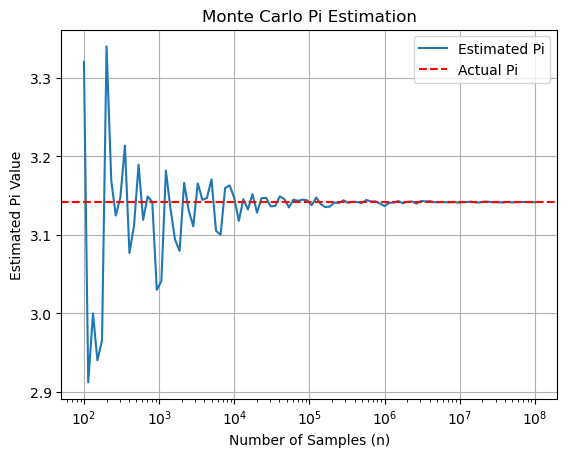

In [136]:
#Part 2 Convergence with n_range
n_range = np.logspace(2, 8, num = 100, base=10, dtype = 'int64')
pi_est_list = np.zeros((100,), dtype=np.float64)
error_list = np.zeros((100,), dtype=np.float64)

for i, n in enumerate(n_range):
    pi_est = estimate_pi(n)
    pi_est_list[i] = pi_est
    error_list[i] = abs(pi_est - pi)

#Plotting results
plt.plot(n_range, pi_est_list , label='Estimated Pi')
plt.axhline(y=pi, color='r', linestyle='--', label='Actual Pi')
plt.xscale('log')
plt.xlabel('Number of Samples (n)')
plt.ylabel('Estimated Pi Value')
plt.title('Monte Carlo Pi Estimation')
plt.legend()
plt.grid()

After plotting the values we can observe that the estimate is converging to $\pi$. While looking at this I got curious as to the rate at which the error was decreasing.

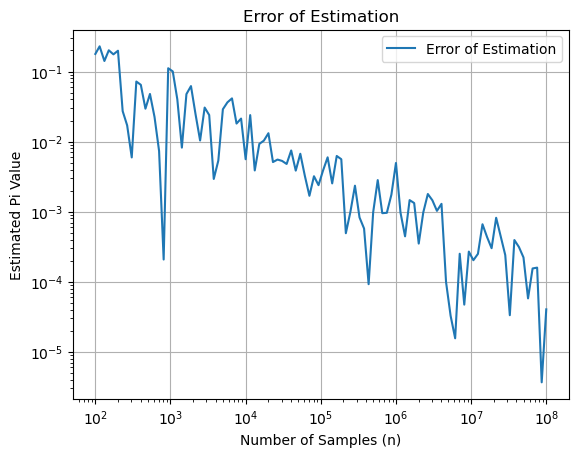

In [137]:
plt.plot(n_range, error_list , label='Error of Estimation')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (n)')
plt.ylabel('Estimated Pi Value')
plt.title('Error of Estimation')
plt.legend()
plt.grid()

We can observe some sort of exponential relationship, after a bit of googling I found that I was emperically finding the [standard error](https://en.wikipedia.org/wiki/Standard_error) of the distribtion. The standard error is defined as $\sigma_{\bar x} = \frac{\sigma}{\sqrt{n}}$. After even further research I found a paper that proves  the "Root mean square error of the Monte Carlo approxmiation is $\\\mathcal{E}_M = \frac{\sigma[X]}{\sqrt{M}}$ [(The MonteCarlo method in a nutshell)](https://www.uio.no/studier/emner/matnat/math/MAT3110/h23/slides-and-lecture-notes/monte_carlo_v2023.pdf) In our example we are sampling a point and checking if it falls within the circle. This is a Bernoulli trial where we can define X=1 if inside, X=0 if outside. From earlier we show that the probability of success is $p=P(X=1) = \frac{\pi/4}{1}=\frac{\pi}{4}$ The varaince of this is simply $\sigma^2=p(1-p)$ Thus in our case 
$$
\begin{align*}
    \sigma^2=\frac{\pi}{4}(1-\frac{\pi}{4}) \\
    \sigma = \sqrt{\frac{\pi}{4}(1-\frac{pi}{4})} \\
    \sigma \approx 0.4106
\end{align*}
$$

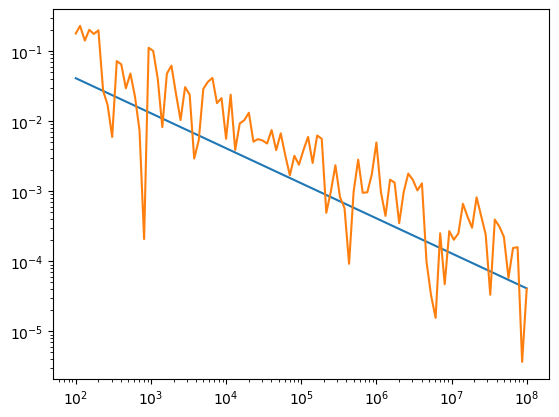

In [138]:
plt.plot(n_range,(0.4106)/np.sqrt(n_range))
plt.plot(n_range, error_list , label='Error of Estimation')
plt.xscale('log')
plt.yscale('log')

Finally we want to choose 3 values of n, and repeat the experiment 500 times. According to the central limit theorm my sampling of  $\pi$'s will be normally distributed with mean near $\pi$ and standard deviation proportional to $\frac{1}{\sqrt{n}}$

In [101]:
def RSamplesOfPi(r, n):
    rOfN = np.zeros((r,))
    for i in range(r):
        rOfN[i] = estimate_pi(n)
    return rOfN

Sample 1 Mean: 3.143704, 1/sqrt(n): 0.03162277660168379 Std Dev: 0.054693403477933264
Sample 2 Mean: 3.141704, 1/sqrt(n): 0.01 Std Dev: 0.016550375947391643
Sample 3 Mean: 3.14183056, 1/sqrt(n): 0.003162277660168379 Std Dev: 0.0052417798967907825


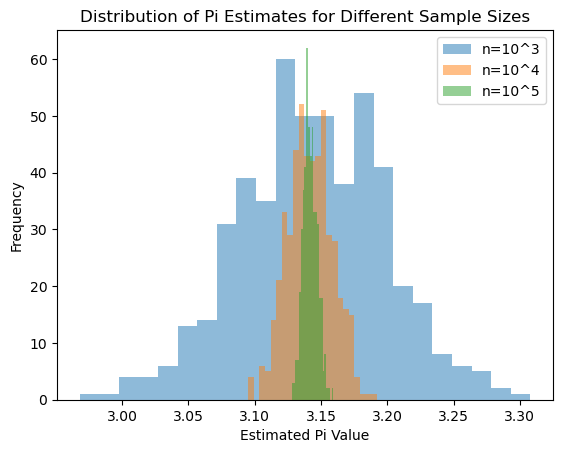

In [152]:

sample1 = np.array(RSamplesOfPi(500,10**3))
sample2 = np.array(RSamplesOfPi(500,10**4))
sample3 = np.array(RSamplesOfPi(500,10**5))



print(f"Sample 1 Mean: {np.mean(sample1)}, 1/sqrt(n): {1/np.sqrt(10**3)} Std Dev: {np.std(sample1)}")
print(f"Sample 2 Mean: {np.mean(sample2)}, 1/sqrt(n): {1/np.sqrt(10**4)} Std Dev: {np.std(sample2)}")
print(f"Sample 3 Mean: {np.mean(sample3)}, 1/sqrt(n): {1/np.sqrt(10**5)} Std Dev: {np.std(sample3)}")

plt.hist(sample1, bins=23, alpha=0.5, label='n=10^3')
plt.hist(sample2, bins=23, alpha=0.5, label='n=10^4')
plt.hist(sample3, bins=23, alpha=0.5, label='n=10^5')

#plt.axvline(x=pi, color='r', linestyle='--', label='Actual Pi')
plt.xlabel('Estimated Pi Value')
plt.ylabel('Frequency')
plt.title('Distribution of Pi Estimates for Different Sample Sizes')
plt.legend()
plt.show()
